# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [70]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [71]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [72]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

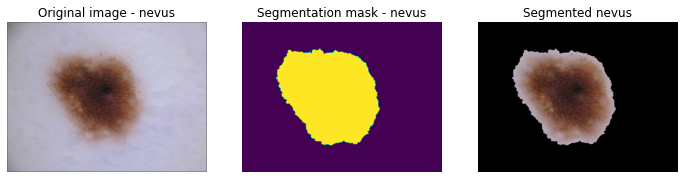

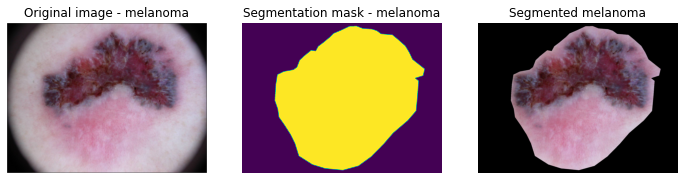

In [73]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [74]:
# Shuffle data randomly
from sklearn.utils import shuffle
Xp= X.copy()
yp= y.copy()
Xp, yp = shuffle(Xp, yp)

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

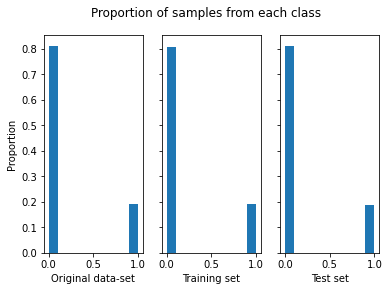

In [75]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

**Answer:** In my opinion we should do it separetely because otherwise the scaling factor used in the test set would be also influenced by our training set, and we should separate the most the operations done in these sets.

In [76]:
# Scale data (each feature will have average equal to 0 and unit variance)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

The QDA performed slightly better in relation to the LDA

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       146
           1       0.67      0.29      0.41        34

    accuracy                           0.84       180
   macro avg       0.76      0.63      0.66       180
weighted avg       0.82      0.84      0.81       180

Normalized confusion matrix
[[0.96575342 0.03424658]
 [0.70588235 0.29411765]]


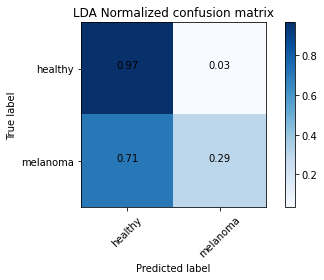

FItting QDA to training set: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       146
           1       0.73      0.24      0.36        34

    accuracy                           0.84       180
   macro avg       0.79      0.61      0.63       180
weighted avg       0.82      0.84      0.80       180

Normalized confusion matrix
[[0.97945205 0.02054795]
 [0.76470588 0.23529412]]


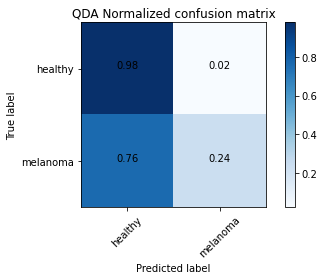

In [77]:
# Fitting LDA
print("Fitting LDA to training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("FItting QDA to training set: ")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()


The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

We could use a cross-validation technique such as K-Folds.

In [78]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, Xp, yp)
print(scores, "\nMean: ", scores.mean(), "\nStandard Deviation: ", scores.std())


# Fitting QDA
print("Fitting QDA")
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, Xp, yp)
print(scores, "\nMean: ", scores.mean(), "\nStandard Deviation: ", scores.std())

# Fitting K-nearest neighbour
print("Fitting KNN")
KNN = KNeighborsClassifier()
scores = cross_val_score(qda, Xp, yp)
print(scores, "\nMean: ", scores.mean(), "\nStandard Deviation: ", scores.std())

Fitting LDA
[0.81666667 0.8        0.83333333 0.80833333 0.825     ] 
Mean:  0.8166666666666668 
Standard Deviation:  0.011785113019775782
Fitting QDA
[0.80833333 0.74166667 0.80833333 0.8        0.84166667] 
Mean:  0.8 
Standard Deviation:  0.03248931448269654
Fitting KNN
[0.80833333 0.74166667 0.80833333 0.8        0.84166667] 
Mean:  0.8 
Standard Deviation:  0.03248931448269654


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

Yes, almost everything was classified as healthy lesions. This happened because the model that yielded the best parameters was an overfitted model because of a bad choice of score. In this dataset it was probably caused by imbalance in number of cases of healthy and melanoma lesions.

Best training Score: 0.8119047619047619
Best training params: {'n_neighbors': 2}
Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.82352941 0.17647059]]


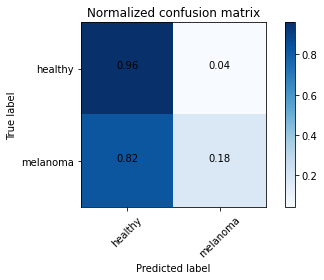

In [79]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

**Answer:** Since the worst kind of error here would be the misclassification of melanoma lesions as healthy lesions. We could also use balanced_accuracy to kind of balance the dataset.

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: 'str' object is not callable

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib

Best training Score: nan
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.7739726 0.2260274]
 [0.5       0.5      ]]


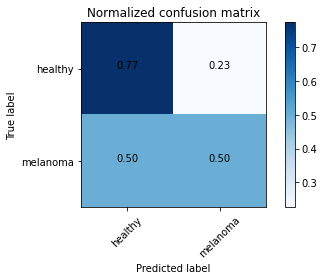

In [99]:
# Looking for the best hyperparameters
import sklearn.metrics
from sklearn.metrics import make_scorer
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
scoring_technique = make_scorer('recall')

grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring=scoring_technique, cv=5) 
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

In [81]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 357)]


In [106]:
from imblearn.over_sampling import RandomOverSampler

naive_ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = naive_ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 339)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

If we use the balanced_accuracy we would have no change since it would be almost the same as upsampling the dataset, but if we use the score function to penalize yet more the false negatives we can still see some improvement.

Best training Score: 0.8477286742034943
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.63013699 0.36986301]
 [0.38235294 0.61764706]]


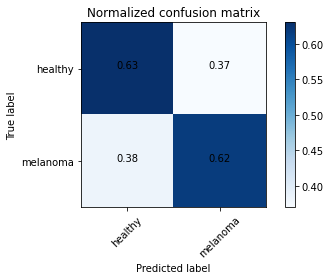

In [82]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: 'str' object is not callable

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib

Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.63013699 0.36986301]
 [0.38235294 0.61764706]]


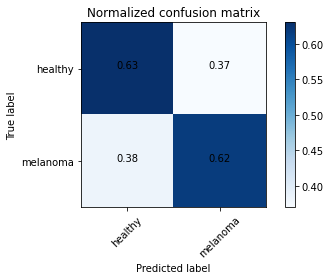

In [83]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
scoring_technique = make_scorer('recall', pos_label="healthy")

grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring=scoring_technique, cv=5) 
grid_KNN.fit(X_resampled, y_resampled)
#print("Best training Score: {}".format(grid_KNN.best_score_)) # This is not available when the param scoring is a callable
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use the techniques seen today: Perceptron and linear SVM. 

In [84]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.49541666666666667 +- 0.2622631206335432
 Average and std TEST CV accuracy : 0.48166666666666663 +- 0.25261960863453703
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.5775 +- 0.28779393187178604
 Average and std TEST CV accuracy : 0.5733333333333335 +- 0.28520947467509644


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [85]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('recall', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Perc_cv['train_recall'].mean(), Perc_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Perc_cv['test_recall'].mean(), Perc_cv['test_recall'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('recall', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Lsvm_cv['train_recall'].mean(), Lsvm_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Lsvm_cv['test_recall'].mean(), Lsvm_cv['test_recall'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_recall', 'train_recall', 'test_f1', 'train_f1'])
 Average and std TRAIN CV recall : 0.658695652173913 +- 0.3492227394359228
 Average and std TEST CV recall : 0.6521739130434783 +- 0.3467374267369893
 Average and std TRAIN CV f1 : 0.3280082205066434 +- 0.024958508406233655
 Average and std TEST CV f1 : 0.3153966642752085 +- 0.02627768830018291
Fitting Linear SVM
 Average and std TRAIN CV recall : 0.04565217391304348 +- 0.03464647271849832
 Average and std TEST CV recall : 0.034782608695652174 +- 0.05070392952039392
 Average and std TRAIN CV f1 : 0.08011894967438933 +- 0.053843605802569944
 Average and std TEST CV f1 : 0.058045977011494256 +- 0.08112206891307534


**Question** Please do the same on the oversampled data and compare the results with the previous ones.

**Answer:** Using the accuracy parameter we could think that the results were better with the non resampled, but if we choose the recall as the scoring parameter we can see that the upsampled better had better scores. We can also see that by the confusion matrix, where we can see improvements in the perceptron and similar results to the SVM:

Normalized confusion matrix
[[0.55479452 0.44520548]
 [0.17647059 0.82352941]]
Normalized confusion matrix
[[0.7260274  0.2739726 ]
 [0.20588235 0.79411765]]


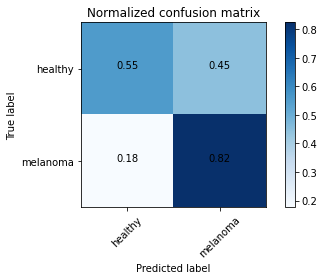

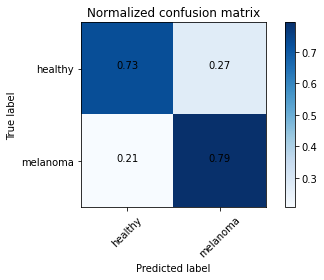

In [86]:
Perc = Perceptron()
Perc.fit(Xp, yp)
y_pred = Perc.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# SVM
Lsvm = LinearSVC() 
Lsvm.fit(Xp, yp)
y_pred = Lsvm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

Shape of data:  (600, 30)
Shape of resampled data:  (696, 30)
Normalized confusion matrix
[[0.6369863  0.3630137 ]
 [0.11764706 0.88235294]]
Normalized confusion matrix
[[0.73287671 0.26712329]
 [0.20588235 0.79411765]]


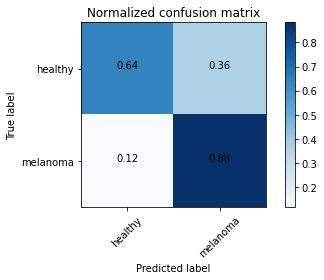

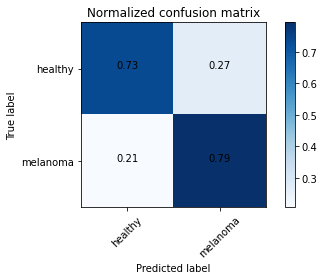

In [87]:
# Perceptron
X_resampled_All, y_resampled_All = ros.fit_resample(Xp, yp)
print("Shape of data: ", Xp.shape)
print("Shape of resampled data: ", X_resampled.shape)
Perc = Perceptron()
Perc.fit(X_resampled_All, y_resampled_All)
y_pred = Perc.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# SVM
Lsvm = LinearSVC() 
Lsvm.fit(X_resampled_All, y_resampled_All)
y_pred = Lsvm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

In [88]:

# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled_All, y_resampled_All, cv=5,scoring=('recall', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Perc_cv['train_recall'].mean(), Perc_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Perc_cv['test_recall'].mean(), Perc_cv['test_recall'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled_All, y_resampled_All, cv=5,scoring=('recall', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV recall : {0} +- {1}".format(Lsvm_cv['train_recall'].mean(), Lsvm_cv['train_recall'].std() ))
print(" Average and std TEST CV recall : {0} +- {1}".format(Lsvm_cv['test_recall'].mean(), Lsvm_cv['test_recall'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_recall', 'train_recall', 'test_f1', 'train_f1'])
 Average and std TRAIN CV recall : 0.7751824817518248 +- 0.27874590498315127
 Average and std TEST CV recall : 0.7825242718446602 +- 0.27478301021942797
 Average and std TRAIN CV f1 : 0.626265702806488 +- 0.08385146268693783
 Average and std TEST CV f1 : 0.6290050743983471 +- 0.08458898796155245
Fitting Linear SVM
 Average and std TRAIN CV recall : 0.620400160631186 +- 0.4631834639472715
 Average and std TEST CV recall : 0.6176280220826195 +- 0.46881208847093375
 Average and std TRAIN CV f1 : 0.45192144903455905 +- 0.29075345639708544
 Average and std TEST CV f1 : 0.44558255802292257 +- 0.3007064662614069


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6397252754349483 +- 0.02570598609654733
 Average and std TEST CV accuracy : 0.6307502569373072 +- 0.03708556727140461
 Average and std TRAIN CV f1 : 0.6481816255741698 +- 0.02027733301684186
 Average and std TEST CV f1 : 0.6319564838743237 +- 0.04664707742514971
Normalized confusion matrix
[[0.52739726 0.47260274]
 [0.64705882 0.35294118]]


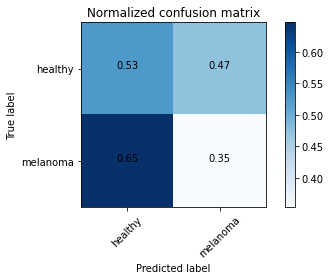

Fitting LinearSVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.745689265463751 +- 0.012162139578590938
 Average and std TEST CV accuracy : 0.6838746145940391 +- 0.038852351980382664
 Average and std TRAIN CV f1 : 0.7558125856896294 +- 0.012639822702383742
 Average and std TEST CV f1 : 0.68635485696302 +- 0.062171173629238366
Normalized confusion matrix
[[0.67808219 0.32191781]
 [0.38235294 0.61764706]]


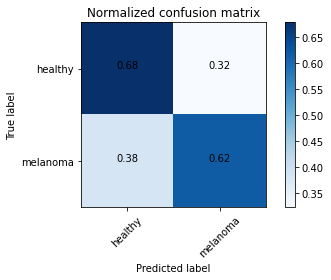

In [89]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM 
print("Fitting LinearSVM")
lsvm = LinearSVC()
lsvm_cv = cross_validate(lsvm,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(lsvm_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(lsvm_cv['train_accuracy'].mean(), lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(lsvm_cv['test_accuracy'].mean(), lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(lsvm_cv['train_f1'].mean(), lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(lsvm_cv['test_f1'].mean(), lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(lsvm_cv['test_accuracy'])
estimator_best=lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: 'str' object is not callable

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib

Best training params: {'C': 0.001}
Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.20588235 0.79411765]]


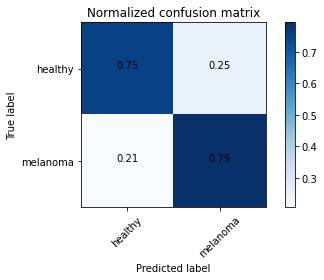

In [90]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
scoring_technique = make_scorer('recall', pos_label="healthy")
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring=scoring_technique, cv=5)
grid_lsvm.fit(X_resampled_All, y_resampled_All)
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training params: {'C': 2, 'gamma': 0.001}
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


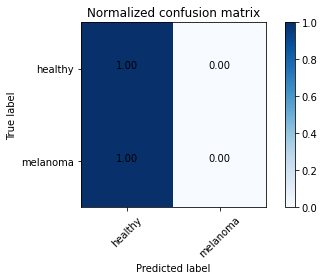

In [94]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_lsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring='accuracy', cv=5)
grid_lsvm.fit(X_resampled_All, y_resampled_All)
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Fitting Non-linear SVM to the training set
Best training params: {'C': 2, 'gamma': 0.001}
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


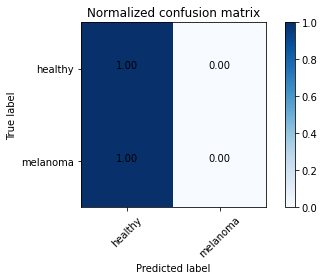

In [105]:
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_lsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring='accuracy', cv=5)
grid_lsvm.fit(X_resampled_All, y_resampled_All)
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer:** The results didn't change. In my opinion this happenened because the data probably is linear, so it didn't demand any mapping to a higher dimentional space.

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

The Perceptron was the best method for this dataset, with a recall scoring function to penalize the FN. It's worth to oversample the data using the Perceptron.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [ ]:
# Test PCA with a linear SVM
XXXXXXXX

In [ ]:
# Fitting Linear SVM 
XXXXXXXXXX

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

XXXXXXXXXX